# Blue Bikes Data Visualization and Feature Analysis

This notebook explores the processed Blue Bikes dataset through visualizations and statistical analysis to understand which factors influence trip demand.

## Contents:
1. **Overall Trip Patterns** - Temporal trends across all stations
2. **Feature Correlation Analysis** - Which features correlate most with trip demand
3. **Case Study: Individual Station Analysis** - Deep dive into one high-volume station
4. **Feature Relationships** - How weather, day of week, and seasonality affect ridership
5. **Key Findings** - Summary of insights for modeling

---

**Data:** Processed dataset from `data/processed/merged_data.csv`

**Date Range:** 2022-01-01 to 2025-09-30

**Stations:** 611 unique stations across Greater Boston (note that only 573 are still active in 2025)

In [1]:
# 03_visualizations.ipynb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed data
df = pd.read_csv('../data/processed/merged_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Loaded {len(df)} rows")
df.head()

Loaded 566622 rows


,station_id,start_station_name,date,trip_count,lat,lng,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break,month,year
0,351,Faneuil St at Arlington St,2022-01-01,1,42.352766,-71.159885,8.2,2.2,10.2,0.0,1,5,1,1,2022
1,351,Faneuil St at Arlington St,2022-01-02,1,42.352766,-71.159885,6.0,6.2,23.2,0.0,0,6,1,1,2022
2,351,Faneuil St at Arlington St,2022-01-03,1,42.352766,-71.159885,-4.0,0.0,22.3,0.0,0,0,1,1,2022
3,351,Faneuil St at Arlington St,2022-01-05,2,42.352766,-71.159885,3.1,6.4,26.4,0.0,0,2,1,1,2022
4,351,Faneuil St at Arlington St,2022-01-06,1,42.352766,-71.159885,1.4,0.0,22.4,0.0,0,3,1,1,2022


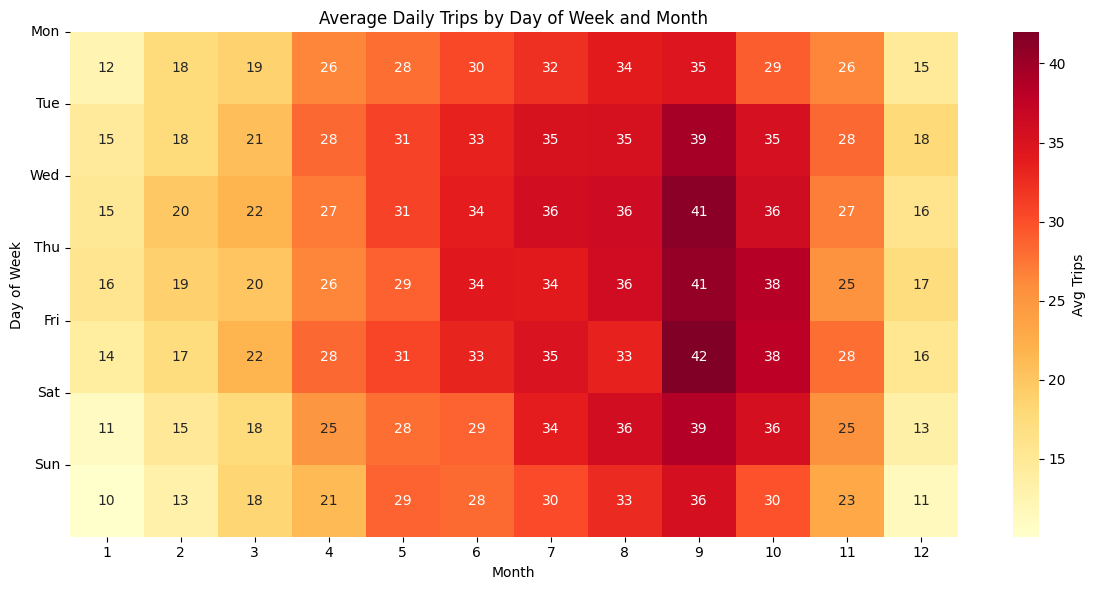

In [14]:
# Aggregate data: average trips per day-of-week and month combination
heatmap_data = df.groupby(['day_of_week', 'month'])['trip_count'].mean().reset_index()

# Pivot for heatmap format
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='month', values='trip_count')

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Avg Trips'})
plt.title('Average Daily Trips by Day of Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week')
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.savefig('../visualizations/day_week_month_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

Stations in core area: 546


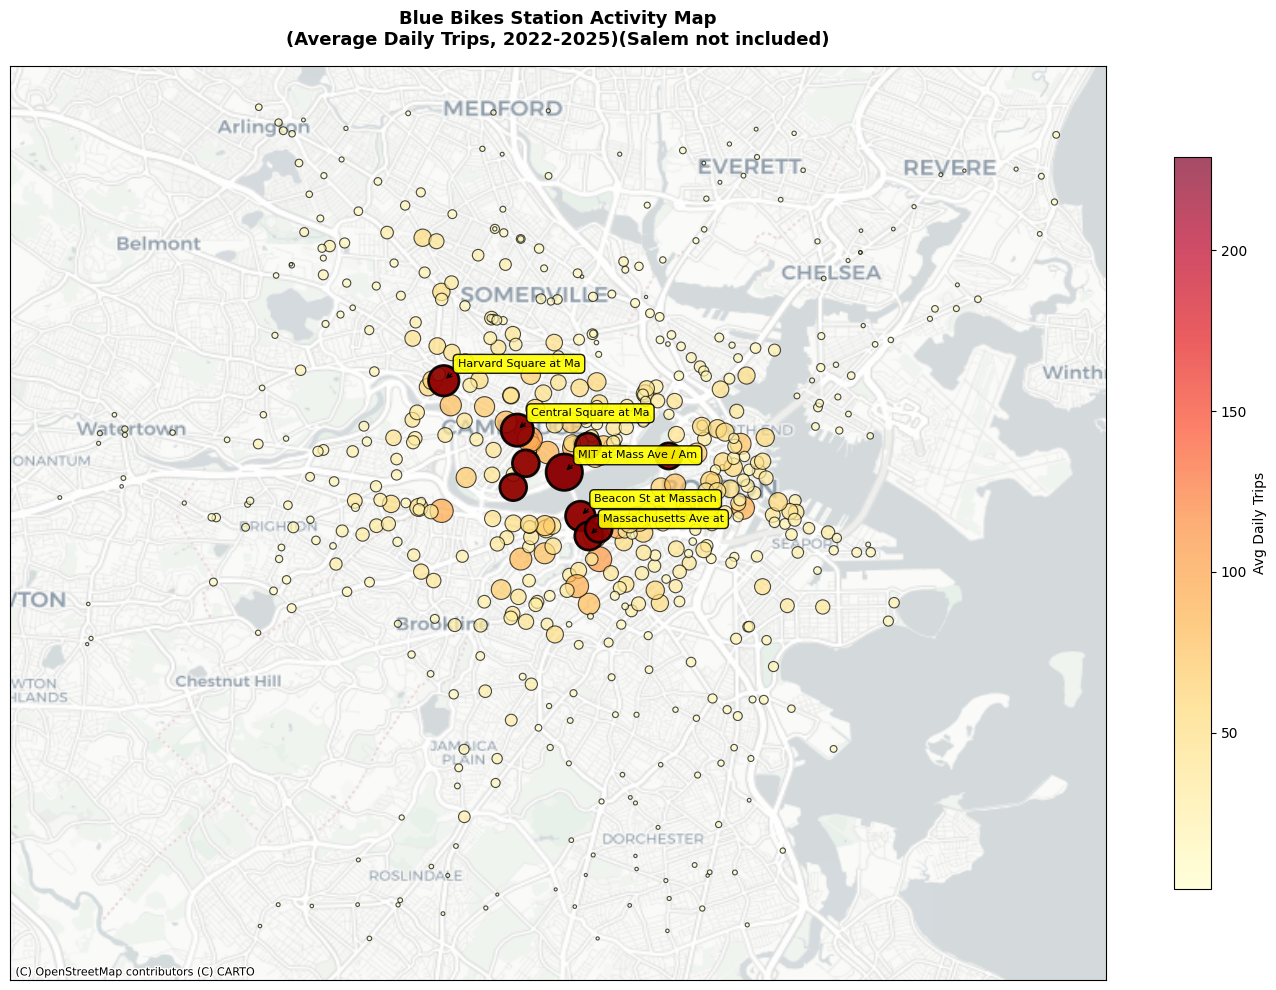

Mapped 546 stations


In [13]:
# Geographic map with real basemap
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer

# Calculate average daily trips per station
station_avg = df.groupby('station_id').agg({
    'trip_count': 'mean',
    'start_station_name': 'first',
    'lat': 'first',
    'lng': 'first'
}).reset_index()
station_avg = station_avg.rename(columns={'trip_count': 'avg_daily_trips'})
station_avg = station_avg.dropna(subset=['lat', 'lng'])

# Filter to core Boston/Cambridge area (remove outliers)
station_avg = station_avg[
    (station_avg['lat'] >= 42.28) & 
    (station_avg['lat'] <= 42.42) &
    (station_avg['lng'] >= -71.20) & 
    (station_avg['lng'] <= -70.98)
]
print(f"Stations in core area: {len(station_avg)}")

# Convert lat/lng to Web Mercator (required for contextily)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
station_avg['x'], station_avg['y'] = transformer.transform(
    station_avg['lng'].values, 
    station_avg['lat'].values
)

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all stations
scatter = ax.scatter(
    station_avg['x'], 
    station_avg['y'],
    s=station_avg['avg_daily_trips'] * 3,
    c=station_avg['avg_daily_trips'],
    cmap='YlOrRd',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.8,
    zorder=5
)

# Highlight top 10
top_10 = station_avg.nlargest(10, 'avg_daily_trips')
ax.scatter(
    top_10['x'],
    top_10['y'],
    s=top_10['avg_daily_trips'] * 3,
    c='darkred',
    alpha=0.9,
    edgecolors='black',
    linewidth=2,
    zorder=6
)

# Add labels for top 5
top_5 = station_avg.nlargest(5, 'avg_daily_trips')
for idx, row in top_5.iterrows():
    short_name = row['start_station_name'][:20]
    ax.annotate(
        short_name,
        xy=(row['x'], row['y']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.9, edgecolor='black'),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', lw=1),
        zorder=7
    )

# Add basemap (try OpenStreetMap style)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

plt.colorbar(scatter, label='Avg Daily Trips', ax=ax, shrink=0.8)
ax.set_xlabel('', fontsize=12)  # Remove axis labels (map has them)
ax.set_ylabel('', fontsize=12)
ax.set_title('Blue Bikes Station Activity Map\n(Average Daily Trips, 2022-2025)(Salem not included)', 
             fontsize=13, fontweight='bold', pad=15)

# Turn off axis numbers (map is self-explanatory)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../visualizations/station_activity_map_with_basemap.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"Mapped {len(station_avg)} stations")